# Training a Jet Tagging with **DNN** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier based on a 
Dense Neural Network (DNN). The problem consists on identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on set of physics-motivated high-level features.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

---

In [2]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jetImage 

(commands starting by ! are shell commands, executed inside python as if from a terminal)

In [ ]:
! git clone https://github.com/pierinim/tutorials.git
! ls tutorials/Data/JetDataset

In [34]:
# get the data from the files
target = np.array([])
features = np.array([])
# we cannot load all data on Colab. So we just take a few files
datafiles = ['tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5',
           'tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5',
            'tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5']
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN, "r")
    myFeatures = np.array(f.get("jets")[:,[12, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 52]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    features = np.concatenate([features, myFeatures], axis=0) if features.size else myFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print("Size of the datasets: X and Y")
print(features.shape, target.shape)
# retrieve feature names
f = h5py.File(datafiles[0], "r")
d = f.get('jetFeatureNames')
featurenames = [d[12], d[34], d[35], d[36], d[37], d[38], d[39], d[40], 
                d[41], d[42], d[43], d[44], d[45], d[46], d[48], d[52]]
print(featurenames[:])

Appending ../../../tutorials/Data/JetDataset/jetImage_7_100p_30000_40000.h5
Appending ../../../tutorials/Data/JetDataset/jetImage_7_100p_60000_70000.h5
Appending ../../../tutorials/Data/JetDataset/jetImage_7_100p_50000_60000.h5
Appending ../../../tutorials/Data/JetDataset/jetImage_7_100p_10000_20000.h5
Appending ../../../tutorials/Data/JetDataset/jetImage_7_100p_0_10000.h5
Size of the datasets: X and Y
(50000, 16) (50000, 5)
[b'j_zlogz', b'j_c1_b0_mmdt', b'j_c1_b1_mmdt', b'j_c1_b2_mmdt', b'j_c2_b1_mmdt', b'j_c2_b2_mmdt', b'j_d2_b1_mmdt', b'j_d2_b2_mmdt', b'j_d2_a1_b1_mmdt', b'j_d2_a1_b2_mmdt', b'j_m2_b1_mmdt', b'j_m2_b2_mmdt', b'j_n2_b1_mmdt', b'j_n2_b2_mmdt', b'j_mass_mmdt', b'j_multiplicity']


In [35]:
# split dataset in training and validation. For lack of data, we will use validation as if they were training
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.33)
print("Size of the datasets: Xtrain, Xvalidation, Ytrain, Yvalidation")
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del features, target

Size of the datasets: Xtrain, Xvalidation, Ytrain, Yvalidation
(33500, 16) (16500, 16) (33500, 5) (16500, 5)


# A close look to the labels Y

In [36]:
print("First five entries:")
print(y_train[:5,:])
print("Last 5 entries:")
print(y_train[-5:,:])

First five entries:
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Last 5 entries:
[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


# Show the distribution of the 16 features for different classes

In [37]:
labelCat= ["gluon", "quark", "W", "Z", "top"]
# this function makes the histogram of a given quantity for the five classes
def makePlot(feature_index, input_data, target, input_featurenames):
    plt.subplots()
    for i in range(len(labelCat)):
        # notice the use of numpy masking to select specific classes of jets
        my_data = input_data[np.argmax(target, axis=1) == i]
        # then plot the right quantity for the reduced array
        plt.hist(my_data[:,feature_index], 50, density=True, histtype='step', fill=False, linewidth=1.5)
    plt.yscale('log', nonposy='clip')    
    plt.legend(labelCat, fontsize=12, frameon=False)  
    plt.xlabel(str(input_featurenames[feature_index], "utf-8"), fontsize=15)
    plt.ylabel('Prob. Density (a.u.)', fontsize=15)
    plt.show()

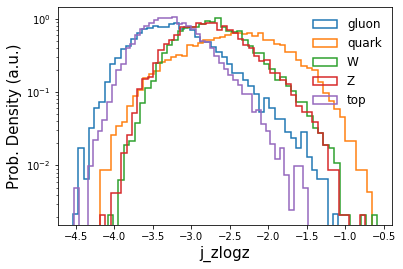

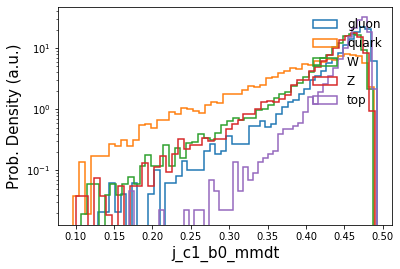

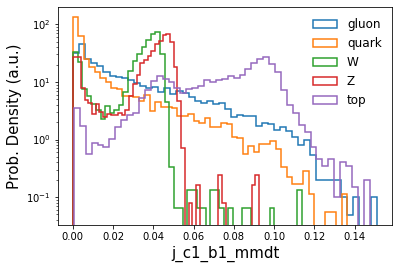

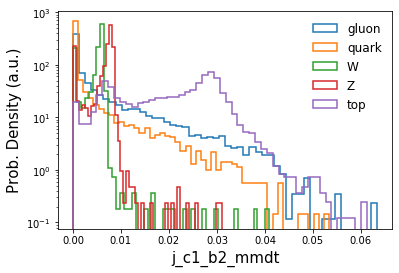

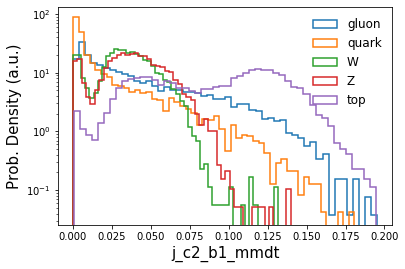

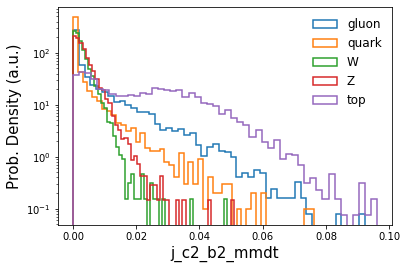

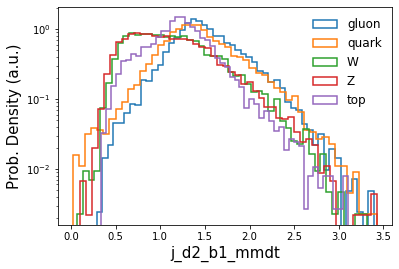

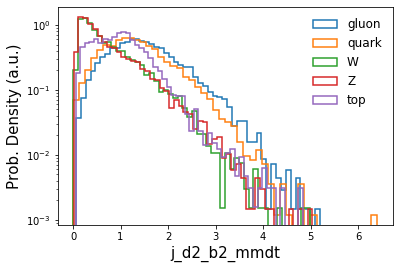

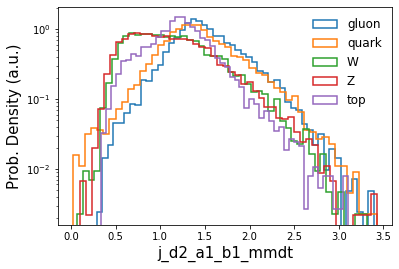

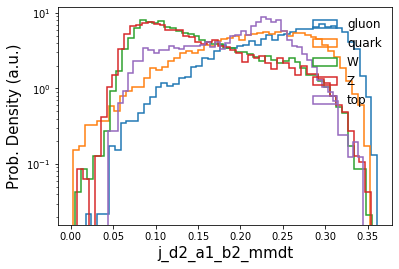

In [38]:
for i in range(len(featurenames[:-6])):
    makePlot(i, X_train, y_train, featurenames)
    #fig.show()

# Now we build and train the Neural Network

In [39]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [40]:
input_shape = X_train.shape[1]
dropoutRate = 0.25

In [41]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputArray, outputs=output)

2022-07-23 17:06:23.456706: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-23 17:06:23.458538: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 40)                680       
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
activation (Activation)      (None, 20)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210   

In [43]:
batch_size = 128
n_epochs = 50
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

2022-07-23 17:06:51.156245: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
262/262 - 1s - loss: 1.6758 - val_loss: 1.4866
Epoch 2/50
262/262 - 0s - loss: 1.5011 - val_loss: 1.4458
Epoch 3/50
262/262 - 0s - loss: 1.4662 - val_loss: 1.4364
Epoch 4/50
262/262 - 0s - loss: 1.4428 - val_loss: 1.3836
Epoch 5/50
262/262 - 0s - loss: 1.4203 - val_loss: 1.3873
Epoch 6/50
262/262 - 0s - loss: 1.4038 - val_loss: 1.3664
Epoch 7/50
262/262 - 0s - loss: 1.3873 - val_loss: 1.3402
Epoch 8/50
262/262 - 0s - loss: 1.3734 - val_loss: 1.3273
Epoch 9/50
262/262 - 0s - loss: 1.3454 - val_loss: 1.3048
Epoch 10/50
262/262 - 0s - loss: 1.3134 - val_loss: 1.2546
Epoch 11/50
262/262 - 0s - loss: 1.2651 - val_loss: 1.1873
Epoch 12/50
262/262 - 0s - loss: 1.2219 - val_loss: 1.1630
Epoch 13/50
262/262 - 0s - loss: 1.1911 - val_loss: 1.1235
Epoch 14/50
262/262 - 0s - loss: 1.1733 - val_loss: 1.1209
Epoch 15/50
262/262 - 0s - loss: 1.1621 - val_loss: 1.0943
Epoch 16/50
262/262 - 0s - loss: 1.1572 - val_loss: 1.0860
Epoch 17/50
262/262 - 0s - loss: 1.1545 - val_loss: 1.0963
Epoch 

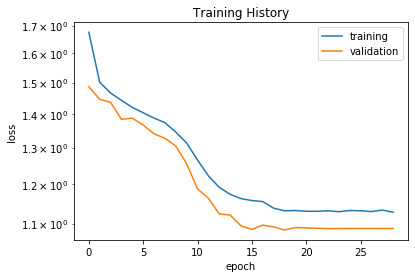

In [44]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

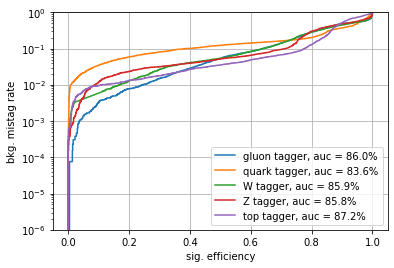

In [46]:
labels = ['gluon', 'quark', 'W', 'Z', 'top']
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_val[:,i]
        df[label + '_pred'] = predict_val[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()